&nbsp;

# 3. Feature Engineering
Feature engineering is the process of selecting, manipulating, and transforming raw data into features that can be used in supervised learning. Feature engineering is one of the most important steps when it comes to a machine learning project because algorithms can only interpret data in a certain way (numerical). For example, categorical data must be binary encoded for it to be considered during the fitting process. Furthermore, there could be features that disrupt the correlation between the label and other features, so removing them is just as important. 

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Importing emsemble models. 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Import functions py file. 
import functions
import visuals

# Import transformers. 
from sklearn.preprocessing import FunctionTransformer, StandardScaler, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Converts plotly output into static images, so it can be viewed inside github repository. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Setting root directory as cwd. 
df = pd.read_csv(r"{}\train.csv".format(root)) # Importing the train set.
df.head(2)

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg
0,6,173.0,110.0,2725,12.6,81,1,chevrolet citation,23.5
1,8,400.0,170.0,4746,12.0,71,1,ford country squire (sw),13.0


&nbsp;

### Section A: Data Preparation
In this section we'll focus on standardizing and normalizing our numerical dataset to hopefully boost performance from our chosen algorithms. However, before we implement these transforms, we must first set our benchmarks. 

**A.1: Benchmarks** <br>
The first step is to set up our benchmarks, so we have a point of reference against which things may be compared. This is a very important step whenever conducting empirical testing. ML algorithms are stochastic in nature, which means not every prediction will be the same. So, it's a good idea to run some predictions n number of times then average out the score to record your loss metric.

In [3]:
# Storing results inside list. 
baseGBRscore= list()

# Running predictions through 5 iterations and recording the average score as the final MSE. 
for i in range(1,6):
    GBR = functions.model_evaluation() # Creating class instance. 
    GBR.preprocessing(df) # Transforming the data (imputing/encoding).
    GBR.add_pipe_component("clf", GradientBoostingRegressor()) # Adding model into pipeline. 
    GBR.cross_validation(df) # Evalauting our model performance through cross validation.  
    baseGBRscore.append(GBR.cv_result) # Appending result into list. 

In [4]:
baseRFRscore= list()

for i in range(1,6):
    RFR = functions.model_evaluation()
    RFR.preprocessing(df)
    RFR.add_pipe_component("clf", RandomForestRegressor())
    RFR.cross_validation(df)
    baseRFRscore.append(RFR.cv_result)

In [5]:
baseXGBscore= list()

for i in range(1,6):
    XGB = functions.model_evaluation()
    XGB.preprocessing(df)
    XGB.add_pipe_component("clf", XGBRegressor())
    XGB.cross_validation(df)
    baseXGBscore.append(XGB.cv_result)

In [6]:
# Setting up benchmarks. 
benchmarkGBR = {"Base_GBR" : GBR.cv_result}
benchmarkRFR = {"Base_RFR" : RFR.cv_result}
benchmarkXGB = {"Base_XGB" : XGB.cv_result}

| Model | Model Type | Benchmark |
|---------|---------|---------|
| **Gradient Boosting Regressor** | Base Model | 8.80 |
| **Random Forest Regressor** | Base Model | 9.29|
| **XGB Regressor** | Base Model | 9.93 |

**A.2: Log Transform** <br>
The log transform is a popular technique used to transform skewed data into a Gaussian distribution. The more symmetrical a distribution is the better "data behaves", and this is also true for machine learning algorithms, since they tend to perform better when the data is normally distributed.

Before we apply our log transform to our train dataset, we must prep the data beforehand. This involves imputing any missing values inside the numerical data types as this may cause disruption in our analysis.

In [7]:
numerical = list(df.select_dtypes(exclude=['object']).columns)
print(f'Numerical columns are: {numerical}')

Numerical columns are: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'mpg']


In [8]:
si = SimpleImputer(strategy="mean") # Setting up our SimpleImputer instance. 
preprocessing = Pipeline(steps=[("s", si)]) # Using a pipeline to avoid data leakage 
data = preprocessing.fit_transform(df[numerical]) # Transforming our data. 
imputedNumerical = pd.DataFrame(data=data, columns=df[numerical].columns) # Storing results into a dataframe. 
imputedNumerical.head(2) # Checking if everything loaded correctly.

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg
0,6.0,173.0,110.0,2725.0,12.6,81.0,1.0,23.5
1,8.0,400.0,170.0,4746.0,12.0,71.0,1.0,13.0


In [9]:
log = FunctionTransformer(np.log1p) # Create a function transformer instance, with log as the argument. 
logDf = log.fit_transform(imputedNumerical) # Fit and transform our imputed data. 
logDf.head(2) # Check to see results. 

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg
0,1.945910,5.159055,4.709530,7.910591,2.610070,4.406719,0.693147,3.198673
1,2.197225,5.993961,5.141664,8.465268,2.564949,4.276666,0.693147,2.639057


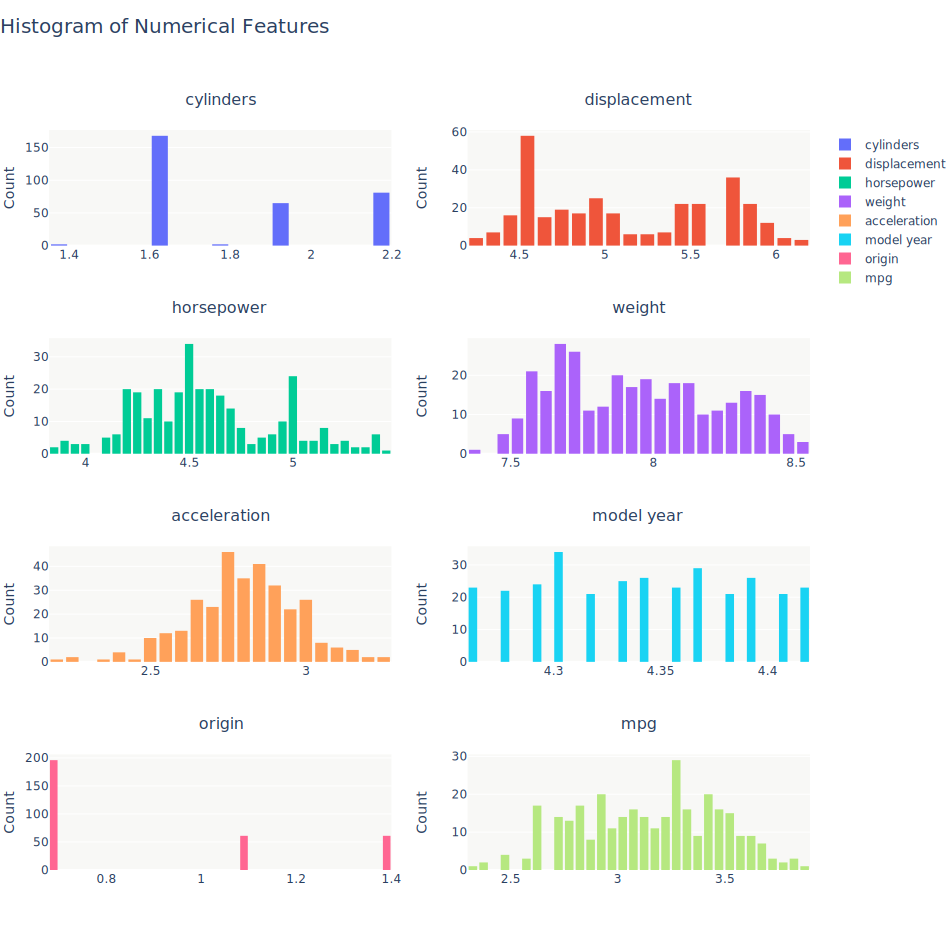

In [10]:
# Plotting distribution of transformed log features. 
visuals.histogram(df=logDf)

* We can see that weight, displacement and horsepower look a lot more symmetrical after our log transformation.
* However, features such as origin, cylinders and model year see little to no change. But this is still an imporvement overall.

**A.3: Testing Hypothesis** <br>
The next step is to test the hypothesis that transforming our data set's scale into log will boost performance of our selected algorithms. Based on the results, we will compare the output against our base benchmarks.

In [11]:
GBR_Log_Score = list()

for i in range(1,6):
    logGBR = functions.model_evaluation()
    logGBR.preprocessing(df)
    logGBR.add_pipe_component("log", FunctionTransformer(np.log1p)) # np.log cannot multiplie 0, so we use np.log1p. 
    logGBR.add_pipe_component("clf", GradientBoostingRegressor())
    logGBR.cross_validation(df)
    GBR_Log_Score.append(logGBR.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(GBR_Log_Score), benchmarkGBR, "GBR_Log")

We accept the null hypothesis.


In [12]:
RFR_Log_Score = list()

for i in range(1,6):
    logRFR = functions.model_evaluation()
    logRFR.preprocessing(df)
    logRFR.add_pipe_component("log", FunctionTransformer(np.log1p)) # np.log cannot multiplie 0, so we use np.log1p. 
    logRFR.add_pipe_component("clf", RandomForestRegressor())
    logRFR.cross_validation(df)
    RFR_Log_Score.append(logRFR.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(RFR_Log_Score), benchmarkRFR, "RFR_Log")

We reject the null hypothesis with the new benchmark for RFR_Log: 9.0308


In [13]:
XGB_Log_Score = list()

for i in range(1,6):
    logXGB = functions.model_evaluation()
    logXGB.preprocessing(df)
    logXGB.add_pipe_component("log", FunctionTransformer(np.log1p)) # np.log cannot multiplie 0, so we use np.log1p. 
    logXGB.add_pipe_component("clf", XGBRegressor())
    logXGB.cross_validation(df)
    XGB_Log_Score.append(logXGB.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(XGB_Log_Score), benchmarkXGB, "XGB_Log")

We reject the null hypothesis with the new benchmark for XGB_Log: 9.9899


| Model | Model Type | Benchmark |
|---------|---------|---------|
| **Gradient Boosting Regressor** | Log Transformed | 8.70 |
| **Random Forest Regressor** | Base Model | 9.29 |
| **XGB Regressor** | Log Transformed | 9.99 |

**A.4: Standardization** <br>
Now it's time to test out standardizing our dataset. Standardization converts the mean to 0 and a standard deviation of 1. Usually this transform is conducted on Gaussian distributions. Standardizing your dataset can potentially lead you to an uplift in performance.

In [14]:
GBR_Standardized_Score = list()

for i in range(1,6):
    sGBR = functions.model_evaluation()
    sGBR.preprocessing(df)
    sGBR.add_pipe_component("s", StandardScaler()) # np.log cannot multiplie 0, so we use np.log1p. 
    sGBR.add_pipe_component("clf", GradientBoostingRegressor())
    sGBR.cross_validation(df)
    GBR_Standardized_Score.append(sGBR.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(GBR_Standardized_Score), benchmarkGBR, "GBR_Standardization")

We accept the null hypothesis.


In [15]:
RFR_Standardized_Score = list()

for i in range(1,6):
    sRFR = functions.model_evaluation()
    sRFR.preprocessing(df)
    sRFR.add_pipe_component("s", StandardScaler()) # np.log cannot multiplie 0, so we use np.log1p. 
    sRFR.add_pipe_component("clf", RandomForestRegressor())
    sRFR.cross_validation(df)
    RFR_Standardized_Score.append(sRFR.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(RFR_Standardized_Score), benchmarkRFR, "RFR_Standardization")

We accept the null hypothesis.


In [16]:
XGB_Standardized_Score = list()

for i in range(1,6):
    sXGB = functions.model_evaluation()
    sXGB.preprocessing(df)
    sXGB.add_pipe_component("s", StandardScaler()) # np.log cannot multiplie 0, so we use np.log1p. 
    sXGB.add_pipe_component("clf", XGBRegressor())
    sXGB.cross_validation(df)
    XGB_Standardized_Score.append(sXGB.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(XGB_Standardized_Score), benchmarkXGB, "XGB_Standardization")

We reject the null hypothesis with the new benchmark for XGB_Standardization: 9.9673


| Model | Model Type | Benchmark |
|---------|---------|---------|
| **Gradient Boosting Regressor** | Standardized | 8.68 |
| **Random Forest Regressor** | Base Model | 9.29 |
| **XGB Regressor** | Standardized | 9.97 |

**A.5: Normalization** <br>
Normalization is the process of rescaling the dataset to the range of 0 to 1.

In [17]:
GBR_Normalized_Score = list()

for i in range(1,6):
    nGBR = functions.model_evaluation()
    nGBR.preprocessing(df)
    nGBR.add_pipe_component("n", Normalizer()) # np.log cannot multiplie 0, so we use np.log1p. 
    nGBR.add_pipe_component("clf", GradientBoostingRegressor())
    nGBR.cross_validation(df)
    GBR_Normalized_Score.append(nGBR.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(GBR_Normalized_Score), benchmarkGBR, "GBR_Normalized")

We accept the null hypothesis.


In [18]:
RFR_Normalized_Score = list()

for i in range(1,6):
    nRFR = functions.model_evaluation()
    nRFR.preprocessing(df)
    nRFR.add_pipe_component("n", Normalizer()) # np.log cannot multiplie 0, so we use np.log1p. 
    nRFR.add_pipe_component("clf", RandomForestRegressor())
    nRFR.cross_validation(df)
    RFR_Normalized_Score.append(nRFR.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(RFR_Normalized_Score), benchmarkRFR, "RFR_Normalized")

We accept the null hypothesis.


In [19]:
XGB_Normalized_Score = list()

for i in range(1,6):
    nXGB = functions.model_evaluation()
    nXGB.preprocessing(df)
    nXGB.add_pipe_component("n", Normalizer()) # np.log cannot multiplie 0, so we use np.log1p. 
    nXGB.add_pipe_component("clf", XGBRegressor())
    nXGB.cross_validation(df)
    XGB_Normalized_Score.append(nXGB.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(XGB_Normalized_Score), benchmarkXGB, "XGB_Normalized")

We accept the null hypothesis.


| Model | Model Type | Benchmark |
|---------|---------|---------|
| **Gradient Boosting Regressor** | Standardized | 8.68 |
| **Random Forest Regressor** | Base Model | 9.29 |
| **XGB Regressor** | Standardized | 9.97 |

&nbsp;

### Section B: Correlation Analysis
Correlation analysis is an important step at understanding the relationships with the underlying data and target variable. It is basically a feature elimination technique used to filter out those features that share a weak correlation (whether its positive or negative), and keep those that share a strong relationship with the labelled data.  

**B.1: Correlation Matrix** <br>
A correlation matrix is a table that displays the correlation between every possible variable. It's a useful visual to measure the correlation of each feature against the target variable.

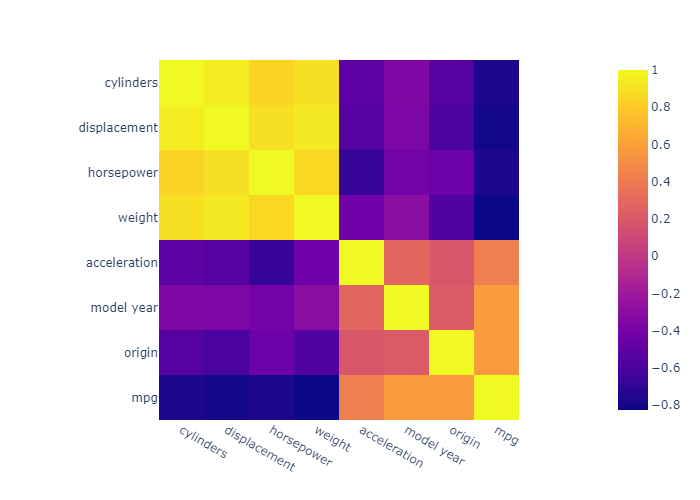

In [20]:
# Transforming our dataframe into pairwise correlation of all columns. 
corr = imputedNumerical.corr()
fig = px.imshow(corr) # Visualizing correlation through heatmap. 
fig.show(renderer="png") # Displaying heatmap. 

* Focusing on the rows for our label (mpg), we can see the features with the strongest correlation are: weight, horsepower, displacement and cylinders.
* What's also interesting to point out is that those particular features have a strong negative correlations with our target variable.
* Another thing to note is that there doesn't seem to be much multicollinearity, which is a good thing, as it can disrupt the performance of a regression model.

**B.2: Scatter Matrix** <br>
A scatter matrix is a matrix of scatterplots with each feature against the target variable. Just like a corrleation matrix, it is a measure of how strong a feature's relationship is with the label.

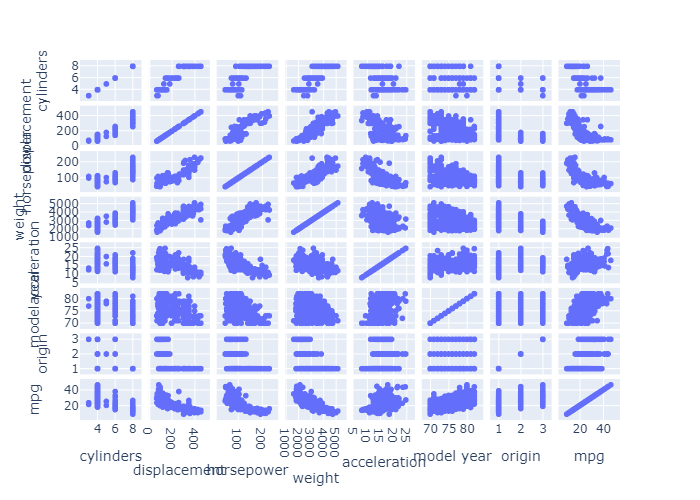

In [21]:
fig = px.scatter_matrix(imputedNumerical) # Plotting scatter matrix. 
fig.show(renderer="png") # Displaying visual, render as png to visualize on github.

* Our scatter matrix is telling us the exact same thing as our corrleation matrix, that the features that show the strongest relationship with our target variable are: horsepower, weight and displacement.
* One thing to note, is that all of the listed features above look to be non-linear, which is maybe why our Linear Regression model performed so badly on the dataset.

&nbsp;

### Section C: Recursive Feature Elimination
In this section we'll focus be focusing on Feature Elimination using scikit-learn's Recrusive Feature Elimination. RFE is a feature elimination technqiue which aims to find the most important features when it comes to predicting our labels. It works through our entire feature space, recursively considering smaller and smaller sets of features. Through each iteration it assigns weights to features (e.g., the feature_importance_ attribute in any classification estimator) and uses this metric to gauge how imporant each feature is at predicting the target variable. At the end of the process, only the most important features are kept.

**C.1: Transforming our Data** <br>
However, before we can conduct RFE, we must transform our feature space so that it's suitable to be inside the algorithm (i.e., impute missing values, encode categorical features).

In [22]:
# Separating our numerical & categorical columns for ColumnTransformer. 
numerical = list(df.select_dtypes(exclude=['object']).columns)
numerical.remove("mpg") # Remove label from data.
print(f'Numerical columns are: {numerical}')

categorical = list(df.select_dtypes(['object']).columns) 
print(f'Categorical columns are: {categorical}')

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor)
])

Numerical columns are: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
Categorical columns are: ['car name']


In [23]:
# Extract SimpleImputer transfrom from the num_pipe.  
num_data = pipe.named_steps['preprocessor'].transformers[1][1].fit_transform(df[numerical])
# Creating dataframe. 
num_df = pd.DataFrame(data=num_data, columns=list(df[numerical].columns))

# Imputing the categorical data. 
imputed_data = pipe.named_steps['preprocessor'].transformers[0][1][0].fit_transform(df[categorical])
imputed_cat =  pd.DataFrame(imputed_data, columns=categorical)

# Encoding the categorical data. 
encoded_data = pipe.named_steps['preprocessor'].transformers[0][1][1].fit_transform(imputed_cat)
cat_df = pd.DataFrame(encoded_data, columns=pipe.named_steps['preprocessor'].transformers[0][1][1].
                      get_feature_names_out(categorical))

# Merging both numerical and categorical features back into a single dataframe. 
merged = pd.concat([cat_df, num_df], axis=1) 
df.reset_index(inplace=True)
processed = pd.concat([merged, df.iloc[:,-1]], axis=1) # Attaching our dependant variable to our processed dataset. 
processed.to_csv(r"{}\processed.csv".format(root), index=False) # Export imputed and encoded data into root directory. 
processed.head(2)

,car name_amc ambassador brougham,car name_amc ambassador dpl,car name_amc ambassador sst,car name_amc concord,car name_amc concord dl,car name_amc concord dl 6,car name_amc gremlin,car name_amc hornet,car name_amc hornet sportabout (sw),car name_amc matador,...,car name_vw rabbit,car name_vw rabbit c (diesel),cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,173.0,110.0,2725.0,12.6,81.0,1.0,23.5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,400.0,170.0,4746.0,12.0,71.0,1.0,13.0


**C.2: Implementing RFEV with Gradient Boosting Regressor** <br>
Now let's implement RFECV onto our base Gradient Boosting Regressor Model.

In [24]:
rfeGBR = functions.model_evaluation()
# arguments(data, model) 
rfeGBR.RFE_cross_validate(processed, GradientBoostingRegressor())
print("Optimal number of features: %d" % rfeGBR.rfe_result.n_features_)

# Store results into a dictionary. 
dictGBR = rfeGBR.rfe_result.cv_results_

Optimal number of features: 17


**C.3: Implementing RFEV with Random Forest Regressor** <br>
Now let's implement RFECV onto our base Random Forest Regressor Model.

In [25]:
rfeRFR = functions.model_evaluation()
# arguments(data, model) 
rfeRFR.RFE_cross_validate(processed, RandomForestRegressor())
print("Optimal number of features: %d" % rfeRFR.rfe_result.n_features_)

# Store results into a dictionary. 
dictRFR = rfeRFR.rfe_result.cv_results_

Optimal number of features: 144


**C.4: Implementing RFEV with XGB Regressor** <br>
Now let's implement RFECV onto our base XGB Regressor Model.

In [26]:
rfeXGB = functions.model_evaluation()
# arguments(data, model) 
rfeXGB.RFE_cross_validate(processed, XGBRegressor())
print("Optimal number of features: %d" % rfeXGB.rfe_result.n_features_)

# Store results into a dictionary. 
dictXGB = rfeXGB.rfe_result.cv_results_

Optimal number of features: 24


**C.5: Plotting the RFECV Output** <br>
Now let's plot the neg_mean_squared_error against the number of features for each algorithm to see at which point the optimal number of features were selected.

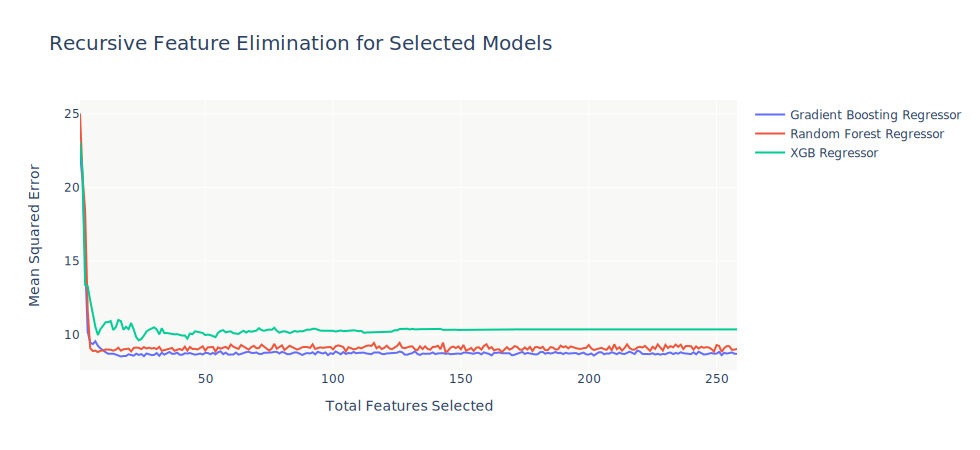

In [27]:
# Setting up axes values. 
x_axis = list(range(1, len(dictGBR['mean_test_score']) + 1)) # Maximum no. of features is 258.
y_axisGBR = abs(dictGBR['mean_test_score'])
y_axisRFR = abs(dictRFR['mean_test_score'])
y_axisXGB = abs(dictXGB['mean_test_score'])

visuals.plot_rfe(xaxis=x_axis, yGBR=y_axisGBR, yRFR=y_axisRFR, yXGB=y_axisXGB)

* In conclusion we saw minor improvements across all models with the RFE technique.
* The small boost in performance does not justify the long training hours it takes to eliminate redundant features for only a 1-2% boost in performance.
* Moving forward, we will not be including RFE into our pipeline, for efficiency purposes.

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  